<a href="https://colab.research.google.com/github/moovingsloth/video-attention-classification/blob/main/DAiSEE_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_%EB%B6%84%EC%84%9D_%EA%B8%B0%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gcsfs tensorflow opencv-python tqdm --quiet

import gcsfs
from google.oauth2 import service_account
from google.colab import drive

drive.mount('/content/drive')

KEY_PATH = '/content/drive/MyDrive/keys/daisee-464310-abc81e54c985.json'
SCOPES = ['https://www.googleapis.com/auth/cloud-platform']

creds = service_account.Credentials.from_service_account_file(
    KEY_PATH,
    scopes=SCOPES
)
fs = gcsfs.GCSFileSystem(project='daisee-464310', token=creds)

GCS_DATASET_DIR = 'gs://colab-daisee-bucket/DAiSEE/DataSet/'
GCS_LABELS_DIR  = 'gs://colab-daisee-bucket/DAiSEE/Labels/'

print("GCSFS ready. KEY_PATH:", KEY_PATH)
print(fs.ls('colab-daisee-bucket/DAiSEE/DataSet/'))
print(fs.ls('colab-daisee-bucket/DAiSEE/Labels/'))

Mounted at /content/drive
GCSFS ready. KEY_PATH: /content/drive/MyDrive/keys/daisee-464310-abc81e54c985.json
['colab-daisee-bucket/DAiSEE/DataSet/', 'colab-daisee-bucket/DAiSEE/DataSet/Test', 'colab-daisee-bucket/DAiSEE/DataSet/Test.txt', 'colab-daisee-bucket/DAiSEE/DataSet/Train', 'colab-daisee-bucket/DAiSEE/DataSet/Train.txt', 'colab-daisee-bucket/DAiSEE/DataSet/Validation', 'colab-daisee-bucket/DAiSEE/DataSet/Validation.txt']
['colab-daisee-bucket/DAiSEE/Labels/AllLabels.csv', 'colab-daisee-bucket/DAiSEE/Labels/TestLabels.csv', 'colab-daisee-bucket/DAiSEE/Labels/TrainLabels.csv', 'colab-daisee-bucket/DAiSEE/Labels/ValidationLabels.csv']


In [3]:
import cv2
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
# Haar Cascade 알고리즘(사전 학습된(Pre-trained) 얼굴 검출 모델, xml 포맷)
HAAR_PATH = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
print("Using Haarcascade:", HAAR_PATH)

Using Haarcascade: /usr/local/lib/python3.11/dist-packages/cv2/data/haarcascade_frontalface_default.xml


In [4]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import cv2
from concurrent.futures import ThreadPoolExecutor, as_completed

# 목표: 손실, 누락된 비디오 파일을 사전에 제거
# 불완전한 프레임 건너뛰기 or 제거
# 프레임 길이가 너무 짧거나 비정상인 크기 필터링
# 타임윈도잉, 슬라이딩 윈도우 (LSTM, TCN 등에 넣을 고정된 시퀀스)
# 불필요한 노이즈 제거(얼굴 검출, ROI)
# 픽셀 레벨 정규화(normalization, equalizeHist())
# Data Augmentation: 좌우뒤집기, 랜덤 크롭, 회전, 색변환 / 시간축 뒤집기
# 클래스 불균형 처리: undersampling/oversampling / class_weight 조정
# one-hot encoding, label smoothing
# TFRecord/TF.Data 파이프라인 구성 - 캐싱, 셔플 등등

# 시간 순서 정보를 고려해 시계열 통계 feature 추가

class DataPreprocessing:
    def __init__(self, fs, bucket: str, base_path: str = 'DAiSEE',
                 IMG_HEIGHT: int = 224, IMG_WIDTH: int = 224,
                 max_frames: int = 3, data_augmentation_flag: bool = False,
                 num_workers: int = 8):
        self.fs = fs
        self.bucket = bucket
        self.base_images = f'{bucket}/{base_path}/DataSet'
        self.base_labels = f'{bucket}/{base_path}/Labels'
        self.IMG_H, self.IMG_W = IMG_HEIGHT, IMG_WIDTH
        self.max_frames = max_frames
        self.data_augmentation_flag = data_augmentation_flag
        self.num_workers = num_workers
        # 얼굴 검출기 초기화
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # 레이블 DataFrame 한 번만 로드
        self.label_dfs = {}
        for split in ('Train','Test','Validation'):
            path = f'{self.base_labels}/{split}Labels.csv'
            with self.fs.open(path,'rb') as f:
                self.label_dfs[split] = pd.read_csv(f)

    def get_video_paths(self, split: str) -> list:
        pattern = f'{self.base_images}/{split}/*/*/*'
        vids = [p for p in self.fs.glob(pattern) if p.lower().endswith(('.avi','.mp4'))]
        print(f"{split}: found {len(vids)} videos")
        return vids

    def extract_frames(self, video_path: str) -> list:
        # 임시 로컬 파일로 프레임 추출
        tmp = '/tmp/tmp_video.avi'
        with self.fs.open(video_path,'rb') as src, open(tmp,'wb') as dst:
            dst.write(src.read())
        cap = cv2.VideoCapture(tmp)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total-1, self.max_frames, dtype=int)
        frames = []
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret: break
            # BGR -> RGB 변환
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        cap.release()
        return frames

    def extract_ts_features(self, frames: list) -> np.ndarray:
      """
      각 비디오에서 추출한 프레임들을 기반으로 시계열 통계 피처 생성
      예시: 밝기 변화량, 얼굴 bounding box 크기 변화 등
      """
      brightness_seq = []
      for f in frames:
          gray = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)
          brightness_seq.append(np.mean(gray))

      # 시계열 통계 feature 예시
      ts = pd.Series(brightness_seq)
      mean_val = ts.mean()
      std_val = ts.std()
      diff_mean = ts.diff().dropna().mean()
      max_slope = np.max(np.gradient(brightness_seq))

      # Feature vector로 반환
      return np.array([mean_val, std_val, diff_mean, max_slope], dtype=np.float32)

    def face_cropping(self, image: np.ndarray) -> np.ndarray:
        # 얼굴 검출 및 크롭, 리사이즈
        faces = self.face_cascade.detectMultiScale(image,1.3,5)
        if len(faces)>0:
            x,y,w,h = faces[0]
            image = image[y:y+h, x:x+w]
        return cv2.resize(image,(self.IMG_W,self.IMG_H), interpolation=cv2.INTER_AREA)

    def augment_image(self, image: np.ndarray) -> list:
        # 간단 증강 연산 정의
        ops = [
            lambda x: tf.image.flip_left_right(x).numpy(),
            lambda x: tf.image.random_brightness(x,0.2).numpy(),
            lambda x: tf.image.random_contrast(x,0.8,1.2).numpy()
        ]
        variants = []
        for op in ops:
            aug = op(image)
            variants.append(cv2.resize(aug,(self.IMG_W,self.IMG_H)))
        return variants

    def _bytes_feature(self, value: bytes) -> tf.train.Feature:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def label_onehot(self, video_path: str, split: str) -> bytes:
        # ClipID 기준 레이블 조회 및 one-hot 변환
        vid = os.path.basename(video_path).rsplit('.',1)[0] + '.avi'
        df = self.label_dfs[split]
        row = df[df['ClipID']==vid]
        if row.empty: return None
        arr = row[['Boredom','Engagement','Confusion','Frustration ']].values[0]

        # Correctly create a one-hot encoded label
        # Find the index of the maximum value
        max_index = np.argmax(arr)
        # Create a one-hot array
        one_hot_label = np.zeros(4, dtype=np.uint8)
        one_hot_label[max_index] = 1

        return one_hot_label.tobytes()


    def _process_video_with_ts(self, video_path: str, split: str) -> list:
        """
        시계열 통계 feature를 포함한 전처리 및 TFRecord example 생성
        """
        lab = self.label_onehot(video_path, split)
        if lab is None:
            return []

        examples = []
        frames = self.extract_frames(video_path)

        # 시계열 통계 feature 추출
        ts_features = self.extract_ts_features(frames).tobytes()

        for frame in frames:
            img = self.face_cropping(frame)
            variants = self.augment_image(img) if self.data_augmentation_flag else [img]
            for v in variants:
                jpeg = tf.io.encode_jpeg(v).numpy()
                feat = {
                    'image': self._bytes_feature(jpeg),
                    'label': self._bytes_feature(lab),
                    'ts_feature': self._bytes_feature(ts_features),
                }
                examples.append(tf.train.Example(features=tf.train.Features(feature=feat)))
        return examples


    def _process_video_simple(self, video_path: str, split: str) -> list:
        """
        시계열 통계를 포함하지 않은 단순 전처리
        """
        lab = self.label_onehot(video_path, split)
        if lab is None:
            return []

        examples = []
        frames = self.extract_frames(video_path)

        for frame in frames:
            img = self.face_cropping(frame)
            variants = self.augment_image(img) if self.data_augmentation_flag else [img]
            for v in variants:
                jpeg = tf.io.encode_jpeg(v).numpy()
                feat = {
                    'image': self._bytes_feature(jpeg),
                    'label': self._bytes_feature(lab)
                }
                examples.append(tf.train.Example(features=tf.train.Features(feature=feat)))
        return examples


    def writeTfRecord(self, output_dir: str = 'tfrecords', use_ts_feature: bool = True):
        """
        TFRecord 저장. use_ts_feature=True면 시계열 통계 포함
        """
        os.makedirs(output_dir, exist_ok=True)
        process_fn = self._process_video_with_ts if use_ts_feature else self._process_video_simple

        for split in ('Train', 'Test', 'Validation'):
            paths = self.get_video_paths(split)
            writer = tf.io.TFRecordWriter(f'{output_dir}/{split.lower()}.tfrecords')
            with ThreadPoolExecutor(max_workers=self.num_workers) as exe:
                futures = {exe.submit(process_fn, vp, split): vp for vp in paths}
                for future in tqdm(as_completed(futures), total=len(paths), desc=split):
                    for ex in future.result():
                        writer.write(ex.SerializeToString())
            writer.close()

    def decode(self, example):
        feature_spec = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string),
            'ts_feature': tf.io.FixedLenFeature([], tf.string, default_value=b'')
        }

        parsed = tf.io.parse_single_example(example, feature_spec)

        img = tf.image.decode_jpeg(parsed['image'], channels=3)
        lab = tf.io.decode_raw(parsed['label'], tf.uint8)
        lab = tf.reshape(lab, [4])

        tsf = tf.io.decode_raw(parsed['ts_feature'], tf.float32)
        tsf = tf.reshape(tsf, [-1])

        return img, tf.cast(lab, tf.float32), tsf

In [5]:
# 1) TensorFlow 불러오기
import tensorflow as tf

# 2) 배치 크기 설정
batch_size = 32

# 3) DataPreprocessing 인스턴스 생성
dp = DataPreprocessing(
    fs=fs,
    bucket='colab-daisee-bucket',
    max_frames=3,
    data_augmentation_flag=False,
    num_workers=8
)

# 4) TFRecord 파일 생성
# print("TFRecord 생성 시작 (with ts_feature)...")
# dp.writeTfRecord(output_dir='tfrecords_ts', use_ts_feature=True)

print("TFRecord 생성 시작 (without ts_feature)...")
dp.writeTfRecord(output_dir='tfrecords_simple', use_ts_feature=False)

# 5) TFRecordDataset 로딩
print("데이터 로딩 중...")

# ds_ts = tf.data.TFRecordDataset('tfrecords_ts/train.tfrecords')
# ds_ts = ds_ts.map(dp.decode, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

ds_simple = tf.data.TFRecordDataset('tfrecords_simple/train.tfrecords')
ds_simple = ds_simple.map(lambda x: dp.decode(x)[:2], num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

TFRecord 생성 시작 (without ts_feature)...
Train: found 5482 videos


Train: 100%|██████████| 5482/5482 [13:56<00:00,  6.55it/s] 


Test: found 1866 videos


Test: 100%|██████████| 1866/1866 [03:26<00:00,  9.02it/s] 


Validation: found 1720 videos


Validation: 100%|██████████| 1720/1720 [02:28<00:00, 11.57it/s] 


데이터 로딩 중...


In [10]:
print("\nWithout time-series feature:")
for imgs, labs in ds_simple.take(1): # Unpack only two values
    print("images:", imgs.shape)
    print("labels:", labs.shape)
    # print("ts_features:", tsf.shape) # This line is now commented out as tsf is not available
    # print("예시 ts_feature[0]:", tsf[0].numpy()) # This line is now commented out


Without time-series feature:
images: (32, 224, 224, 3)
labels: (32, 4)


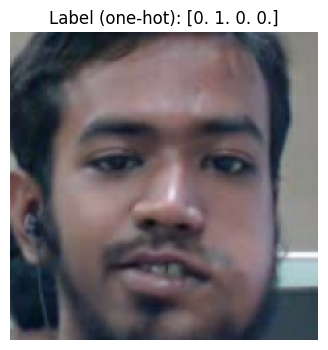

In [11]:
import matplotlib.pyplot as plt

# 샘플 배치 불러오기
for imgs, labs in ds_simple.take(1): # Unpack only two values
    sample_img = imgs[0].numpy()
    sample_label = labs[0].numpy()
    break

# 시각화
plt.figure(figsize=(4, 4))
plt.imshow(sample_img.astype('uint8'))
plt.title(f"Label (one-hot): {sample_label}")
plt.axis('off')
plt.show()

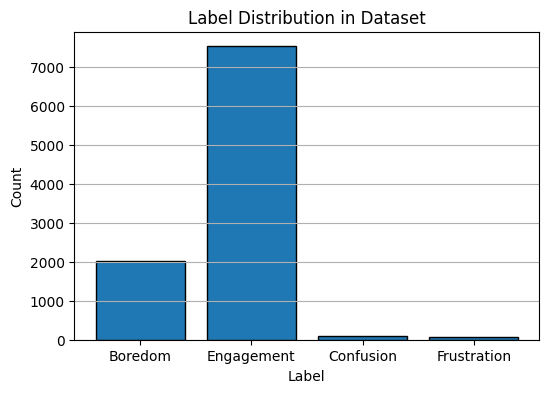

In [13]:
import numpy as np

# 레이블 수집
all_labels = []

for imgs, labs in ds_simple: # Unpack only two values
    all_labels.extend(np.argmax(labs.numpy(), axis=1))  # one-hot → 정수 라벨로 변환

# 레이블 이름 지정 (DAiSEE 기준)
label_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

# 분포 시각화
plt.figure(figsize=(6, 4))
plt.hist(all_labels, bins=np.arange(5) - 0.5, edgecolor='black', rwidth=0.8)
plt.xticks(range(4), label_names)
plt.title("Label Distribution in Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

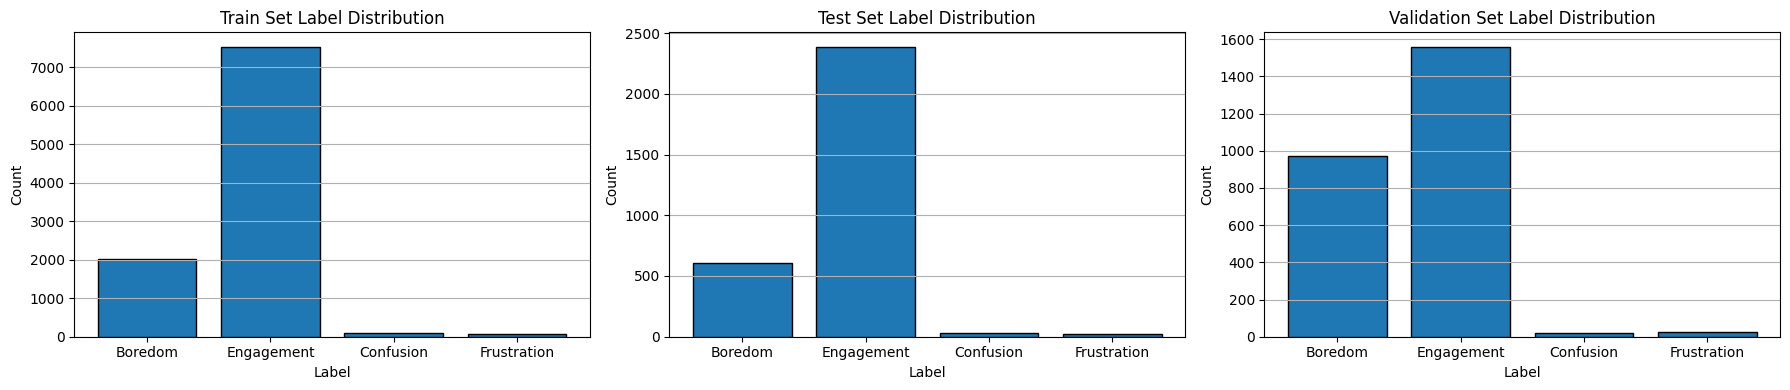

In [14]:
# TFRecordDataset 로딩
ds_train = tf.data.TFRecordDataset('tfrecords_simple/train.tfrecords')
ds_test  = tf.data.TFRecordDataset('tfrecords_simple/test.tfrecords')
ds_val   = tf.data.TFRecordDataset('tfrecords_simple/validation.tfrecords')

ds_train = ds_train.map(dp.decode).batch(batch_size)
ds_test  = ds_test.map(dp.decode).batch(batch_size)
ds_val   = ds_val.map(dp.decode).batch(batch_size)

def get_label_distribution(dataset):
    all_labels = []
    for _, labs, _ in dataset:
        all_labels.extend(np.argmax(labs.numpy(), axis=1))
    return np.array(all_labels)


# 레이블 이름
label_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

# 분포 수집
train_labels = get_label_distribution(ds_train)
test_labels  = get_label_distribution(ds_test)
val_labels   = get_label_distribution(ds_val)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
splits = ['Train', 'Test', 'Validation']
datasets = [train_labels, test_labels, val_labels]

for i, (labels, split) in enumerate(zip(datasets, splits)):
    axes[i].hist(labels, bins=np.arange(5) - 0.5, edgecolor='black', rwidth=0.8)
    axes[i].set_xticks(range(4))
    axes[i].set_xticklabels(label_names)
    axes[i].set_title(f"{split} Set Label Distribution")
    axes[i].set_xlabel("Label")
    axes[i].set_ylabel("Count")
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

In [16]:
from collections import Counter

for name, labels in zip(['Train', 'Test', 'Validation'], [train_labels, test_labels, val_labels]):
    print(f"\n{name} Set Label Counts:")
    for i, count in sorted(Counter(labels).items()):
        print(f"  {label_names[i]}: {count}")


Train Set Label Counts:
  Boredom: 2030
  Engagement: 7529
  Confusion: 103
  Frustration: 68

Test Set Label Counts:
  Boredom: 606
  Engagement: 2387
  Confusion: 28
  Frustration: 24

Validation Set Label Counts:
  Boredom: 973
  Engagement: 1559
  Confusion: 19
  Frustration: 25


In [15]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_functional_model(input_shape, batch_size):
    # Define the input layer with a specified batch size
    inputs = tf.keras.Input(shape=input_shape, batch_size=batch_size)

    # Add Rescaling
    x = layers.Rescaling(1./255)(inputs)

    # Add Convolutional and MaxPooling layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Explicit Reshape before the dense layers
    # Calculate the flattened size: 54 * 54 * 64
    flattened_size = 54 * 54 * 64
    x = layers.Reshape((flattened_size,))(x) # Reshape to (batch_size, flattened_size)

    # Add Dense layers with Dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Define input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Build and compile the model
model = build_functional_model(input_shape, batch_size)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (32, 186624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
for img, lab in ds_simple.take(1):
    print("image shape:", img.shape)   # (32, 224, 224, 3)
    print("label shape:", lab.shape)   # ✅ 반드시 (32, 4) 여야 함
    # print("tsf shape:", tsf.shape)     # (32, 0) 또는 제외 가능

image shape: (32, 224, 224, 3)
label shape: (32, 4)


In [20]:
ds_val = tf.data.TFRecordDataset('tfrecords_simple/validation.tfrecords')
ds_val = ds_val.map(lambda x: dp.decode(x)[:2], num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

In [ ]:
for img, label in ds_simple.take(1):
    print("image shape:", img.shape)

In [23]:
history = model.fit(ds_simple,
                    validation_data=ds_val,
                    epochs=5)

Epoch 1/5
    305/Unknown 937s 3s/step - accuracy: 0.7135 - loss: 4.3197

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 1004s 3s/step - accuracy: 0.7136 - loss: 4.3115 - val_accuracy: 0.6052 - val_loss: 0.7881
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7446 - loss: 0.8022

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 1042s 3s/step - accuracy: 0.7447 - loss: 0.8020 - val_accuracy: 0.6052 - val_loss: 1.8396
Epoch 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7572 - loss: 0.6942

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 1053s 3s/step - accuracy: 0.7572 - loss: 0.6942 - val_accuracy: 0.6052 - val_loss: 0.7733
Epoch 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7689 - loss: 0.6602

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 1094s 3s/step - accuracy: 0.7689 - loss: 0.6602 - val_accuracy: 0.6052 - val_loss: 0.7853
Epoch 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7689 - loss: 0.6494

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


305/305 ━━━━━━━━━━━━━━━━━━━━ 1039s 3s/step - accuracy: 0.7689 - loss: 0.6493 - val_accuracy: 0.6052 - val_loss: 0.7898


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


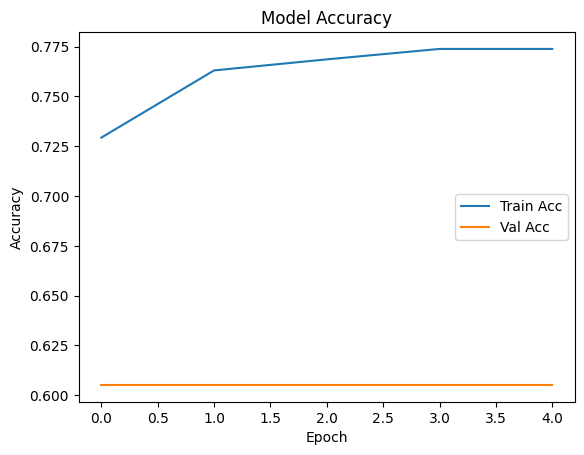

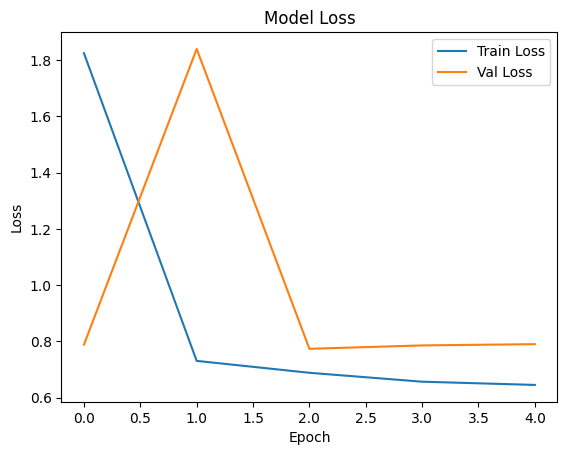

In [24]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, Rescaling

# Build a partial model up to the last MaxPooling2D layer
partial_model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2)
])

# Print the output shape of the partial model
print("Output shape of the last MaxPooling2D layer:", partial_model.output_shape)

Output shape of the last MaxPooling2D layer: (None, 54, 54, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
